# **0. Setting up dependencies**

In [ ]:
!nvidia-smi

Thu Nov  7 09:41:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             17W /  170W |     839MiB /  12288MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    current_device = torch.cuda.current_device()
    print(f"Current GPU device: {current_device}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(current_device)}")
else:
    print("No CUDA-enabled GPU detected.")

CUDA available: True
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3060
Current GPU device: 0
Current GPU device name: NVIDIA GeForce RTX 3060


**Install and Import dependencies**

In [ ]:
!pip install -Uqq fastai nbdev fastbook
!pip install --upgrade fastai sentencepiec

ERROR: Could not find a version that satisfies the requirement sentencepiec (from versions: none)
ERROR: No matching distribution found for sentencepiec


In [ ]:
from fastai.text.all import *
import pandas as pd
import numpy as np
import string

# **1. Importing data**

In [ ]:
df = pd.read_csv("data/film_details.csv")
df

,Title,Category,Url,Metascore,Number_of_critic_reviewers,User_score,Number_of_user_reviewers,Plot_summary,Genres
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,"This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply person...",['Drama']
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,"Francis Ford Coppola's epic features Marlon Brando in his Oscar-winning role as the patriarch of the Corleone family. Director Coppola paints a chilling portrait of the Sicilian clan's rise and near fall from power in America, masterfully balancing the story between the Corleone's family life and the ugly crime business in which they are...","['Crime', 'Drama']"
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-arabia-re-release/,100,8,100,442,"The 40th anniversary re-release of David Lean's 1962 masterpiece, starring Peter O'Toole in one of the most electrifying debuts in film history.","['Adventure', 'Biography', 'Drama', 'War']"
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-re-release/,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spectacular 1963 adaptation of Giuseppe di Lampedusa's international bestseller is one of the cinema's greatest evocations of the past, achingly depicting the passing of an ancient order. (Film Forum)","['Drama', 'History']"
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformist-re-release/,100,11,100,105,"Set in Rome in the 1930s, this re-release of Bernardo Bertolucci's 1970 breakthrough feature stars Jean-Louis Trintignant as a Mussolini operative sent to Paris to locate and eliminate an old professor who fled Italy when the fascists came to power.",['Drama']
...,...,...,...,...,...,...,...,...,...
15149,Cavemen,tv,https://www.metacritic.com/tv/cavemen/,19,13,19,6,"Cavemen revolves around Joel, his younger brother Andy and best friend Nick. Joel is engaged to Kate. Even though he has some problems with her conservative parents accepting him, he is happy with his life and pursuing the American Dream. The pilot is based on the Geico commercials that claim their service is so easy, ""Even a caveman can...","['Comedy', 'Sci-Fi']"
15150,Work It,tv,https://www.metacritic.com/tv/work-it/,19,22,19,44,"After they are laid off, Lee Standish (Ben Koldyke) and Angel Ortiz (Amaury Nolasco) dress up as women to get new jobs as pharmaceutical sales wo(men).",['Comedy']
15151,Category 7: The End of the World,tv,https://www.metacritic.com/tv/category-7-the-end-of-the-world/,18,11,18,7,"""Category 7: The End of the World"" picks up where ""Category 6: Day of Destruction"" left off. The city of Chicago has been destroyed by a monstrous storm and as the storm gathers strength, it threatens to ravage the rest of the world. A television evangelist and his wife prey on the nation’s fears by broadcasting warnings of biblical pl...","['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller']"
15152,Stalker,tv,https://www.metacritic.com/tv/stalker/,17,24,17,137,"Lt. Beth Davis (Maggie Q) leads the Threat Assessment Unit of the Los Angeles Police Department that includes recent transfer Det. Jack Larsen (McDermott), Det. Ben Caldwell (Victor Rasuk), and Det. Janice Lawrence (Mariana Klaveno).","['Crime', 'Drama', 'Thriller']"


In [ ]:
df.shape

(15154, 9)

In [ ]:
df.isna().sum()

Title                         0
Category                      0
Url                           0
Metascore                     0
Number_of_critic_reviewers    0
User_score                    0
Number_of_user_reviewers      0
Plot_summary                  0
Genres                        0
dtype: int64

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
genres_list = df["Genres"]
genres_list

0                                                     ['Drama']
1                                            ['Crime', 'Drama']
2                    ['Adventure', 'Biography', 'Drama', 'War']
3                                          ['Drama', 'History']
4                                                     ['Drama']
                                  ...                          
15149                                      ['Comedy', 'Sci-Fi']
15150                                                ['Comedy']
15151    ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller']
15152                            ['Crime', 'Drama', 'Thriller']
15153                                                ['Comedy']
Name: Genres, Length: 15154, dtype: object

**Only using one category (first category) per film for now for single class classification.**

Will also do multi-label classification later

In [ ]:
genre_list = []
indices_to_drop = []

for idx, genres in enumerate(df.Genres.to_list()):
  genres_list = eval(genres)
  if len(genres_list) != 0 and len(genres_list[0]) != 0:
    genre_list.append(genres_list[0])
  else:
    indices_to_drop.append(idx)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(15149, 9)

In [ ]:
# genre_list

In [ ]:
print(len(genre_list))
print()
print(len(indices_to_drop))

15149

5


In [ ]:
df['Genre'] = genre_list

In [ ]:
df['Genre'].value_counts()

Genre
Comedy         3837
Drama          3470
Action         2437
Documentary    1353
Crime          1199
Biography       825
Adventure       632
Animation       605
Horror          526
Fantasy          63
Reality-TV       48
Thriller         34
Mystery          33
Game-Show        20
Sci-Fi           14
Romance          11
Family           10
Musical           7
Unknown           6
Music             5
Western           4
Film-Noir         4
Talk-Show         2
War               1
History           1
Sport             1
News              1
Name: count, dtype: int64

In [ ]:
# df

# Removing rare genres

Rare genres are the genres that has less than 1% frequency in the entire genre count

**Searching for rare genre names**

In [ ]:
genre_count = df['Genre'].value_counts()
threshold = int(len(df) * 0.01)
rare_genres = [ cat for cat, count in genre_count.items() if count < threshold]
len(rare_genres), rare_genres[:5]

(18, ['Fantasy', 'Reality-TV', 'Thriller', 'Mystery', 'Game-Show'])

**Filtering out rare genre names**

In [ ]:
rare_indices_to_drop = [idx for idx, row in df.iterrows() if row['Genre'] in rare_genres]
len(rare_indices_to_drop)

265

In [ ]:
df = df.drop(rare_indices_to_drop).reset_index(drop=True)
df.shape

(14884, 10)

In [ ]:
df['Genre'].value_counts()

Genre
Comedy         3837
Drama          3470
Action         2437
Documentary    1353
Crime          1199
Biography       825
Adventure       632
Animation       605
Horror          526
Name: count, dtype: int64

In [ ]:
len(df['Genre'].value_counts())

9

In [ ]:
df.describe(include='object')

,Title,Category,Url,Plot_summary,Genres,Genre
count,14884,14884,14884,14884,14884,14884
unique,14253,2,14824,14822,1746,9
top,Robin Hood,movie,https://www.metacritic.com/movie/the-professionals/,"Val, a hard-working live-in housekeeper in modern day Sao Paulo, is perfectly content to take care of every one of her wealthy employers’ needs, from cooking and cleaning to being a surrogate mother to their teenage son, who she has raised since he was a toddler. But when Val’s estranged daughter Jessica suddenly shows up the unspoken bu...",['Drama'],Comedy
freq,4,12403,2,2,1063,3837


In [ ]:
df.head()

,Title,Category,Url,Metascore,Number_of_critic_reviewers,User_score,Number_of_user_reviewers,Plot_summary,Genres,Genre
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,"This masterwork by Krzysztof Kieślowski is one of the twentieth century’s greatest achievements in visual storytelling. Originally made for Polish television, Dekalog focuses on the residents of a housing complex in late-Communist Poland, whose lives become subtly intertwined as they face emotional dilemmas that are at once deeply person...",['Drama'],Drama
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,"Francis Ford Coppola's epic features Marlon Brando in his Oscar-winning role as the patriarch of the Corleone family. Director Coppola paints a chilling portrait of the Sicilian clan's rise and near fall from power in America, masterfully balancing the story between the Corleone's family life and the ugly crime business in which they are...","['Crime', 'Drama']",Crime
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-arabia-re-release/,100,8,100,442,"The 40th anniversary re-release of David Lean's 1962 masterpiece, starring Peter O'Toole in one of the most electrifying debuts in film history.","['Adventure', 'Biography', 'Drama', 'War']",Adventure
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-re-release/,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spectacular 1963 adaptation of Giuseppe di Lampedusa's international bestseller is one of the cinema's greatest evocations of the past, achingly depicting the passing of an ancient order. (Film Forum)","['Drama', 'History']",Drama
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformist-re-release/,100,11,100,105,"Set in Rome in the 1930s, this re-release of Bernardo Bertolucci's 1970 breakthrough feature stars Jean-Louis Trintignant as a Mussolini operative sent to Paris to locate and eliminate an old professor who fled Italy when the fascists came to power.",['Drama'],Drama


# **2. DataLoaders**

In [ ]:
doc(RandomSplitter)

In [ ]:
dls = TextDataLoaders.from_df(df,
                              text_col = 'Plot_summary',
                              label_col = 'Genre',
                              bs = 16,
                              seq_len = 512,
                              splitter = RandomSplitter(valid_pct=0.1, seed=42))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [ ]:
# dls.vocab[0]

In [ ]:
dls.vocab[1]

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror']

In [ ]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj the night shift at xxmaj san xxmaj antonio xxmaj memorial includes manager xxmaj michael xxmaj xxunk ( freddy xxmaj rodriguez ) , xxmaj afghanistan vet xxmaj dr . xxup xxunk xxmaj callahan ( xxunk xxmaj xxunk ) , xxmaj dr . xxmaj jordan xxmaj alexander ( jill xxmaj flint ) , xxmaj dr . xxmaj xxunk xxmaj xxunk ( ken xxmaj leung ) , xxmaj dr . xxmaj drew xxmaj xxunk ( brendan xxmaj fehr ) , xxmaj dr . xxmaj landry de la xxmaj cruz ( xxunk xxmaj alonso ) , resident xxmaj paul xxmaj cummings ( robert xxmaj bailey xxmaj jr . ) , nurse xxmaj kenny ( jr xxmaj xxunk …",Drama
1,"xxbos xxmaj set five years after xxmaj xxunk 3 , xxmaj xxunk with xxmaj sharks return to endanger xxmaj fin ( ian xxmaj ziering ) and the rest of the world . xxmaj xxunk xxunk include xxmaj david xxmaj xxunk , xxmaj shark xxmaj tank 's xxmaj lori xxmaj xxunk and xxmaj robert xxmaj xxunk ; xxmaj dancing xxmaj with the xxmaj stars ' xxmaj kym xxmaj johnson ; xxmaj motley xxmaj xxunk 's xxmaj vince xxmaj neil , xxmaj wayne xxmaj newton , xxmaj xxunk 's xxmaj xxunk xxmaj lee xxmaj xxunk and xxmaj alexandra xxmaj paul , and xxmaj dr . d …",Action
2,"xxbos xxmaj rock of xxmaj ages tells the story of small town girl xxmaj xxunk and city boy xxmaj drew , who meet on the xxmaj sunset xxmaj strip while pursuing their xxmaj hollywood dreams . xxmaj their rock ' n ' roll romance is told through the heart - pounding hits of xxmaj xxunk xxmaj xxunk , xxmaj joan xxmaj jett , xxmaj journey , xxmaj xxunk , xxmaj bon xxmaj jovi , xxmaj night xxmaj ranger , xxup xxunk xxmaj xxunk , xxmaj pat xxmaj xxunk , xxmaj twisted xxmaj sister , xxmaj poison , xxmaj xxunk …",Comedy


In [ ]:
torch.save(dls, "dataloaders/dls_single_class_text_classification.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls_single_class_text_classification.pkl")

# **3. Language Modeling**

In [ ]:
doc(text_classifier_learner)

In [ ]:
learner = text_classifier_learner(dls,
                                AWD_LSTM,
                                drop_mult=0.5,
                                metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learner.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(15808, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(15808, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): B

In [ ]:
learner = learner.load_encoder(f"lm-encoder-finetuned-with-earlyStopping")

**Stage - 0**|

In [ ]:
learner.freeze()

Suggested learning rate (slide): 0.010964781977236271
Suggested learning rate (valley): 0.0012022644514217973
Average learning rate: 0.006083523214329034
Suggested ALR: 6.08e-3


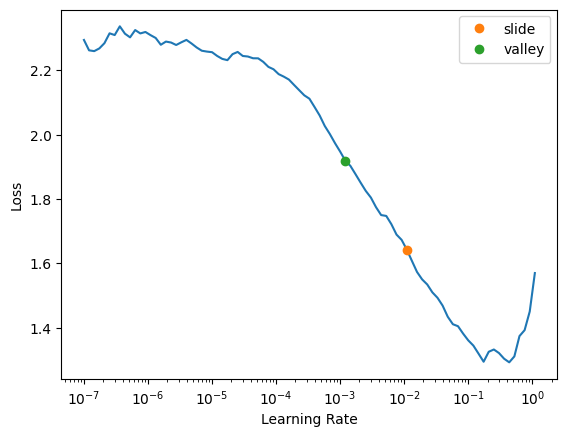

In [ ]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [ ]:
learner.fit_one_cycle(n_epoch = 1, lr_max = average_lr, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=10)) #Takign the average of suggested slide and valley

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.687101,0.505176,0.855511,1.657277,00:19


In [ ]:
learner.fit_one_cycle(n_epoch = 100, lr_max = average_lr, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=10)) #Takign the average of suggested slide and valley

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.689519,0.497517,0.855847,1.644633,00:19
1,0.628829,0.504548,0.852823,1.656237,00:19
2,0.598400,0.495410,0.858871,1.641171,00:19
3,0.598792,0.502197,0.852823,1.652347,00:19
4,0.575865,0.493114,0.854167,1.637408,00:19
5,0.616117,0.504287,0.855175,1.655805,00:19
6,0.650787,0.499464,0.853159,1.647838,00:19
7,0.664287,0.503580,0.852823,1.654635,00:19
8,0.640835,0.500253,0.853495,1.649138,00:19
9,0.620132,0.501954,0.856855,1.651946,00:19


No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

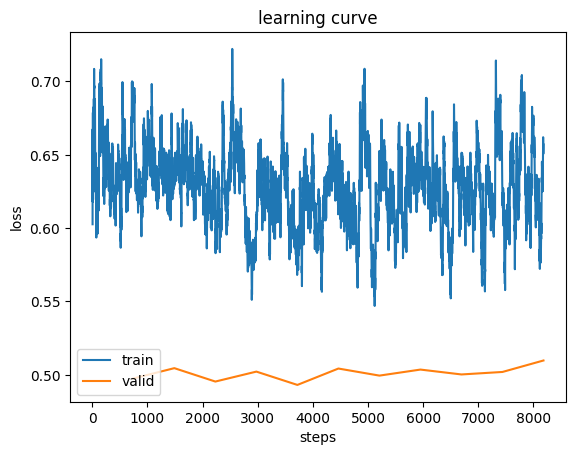

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save(f"sctc_lm-stage-0")

Path('models/sctc_lm-stage-0.pth')

In [ ]:
torch.save(dls, "models/dls_single_class_text_classification_sctc_lm-stage-0.pkl")

**Stage - 1**

In [ ]:
# learner.load(f"sctc_lm-stage-0")

In [ ]:
learner.freeze_to(-2)

Suggested learning rate (slide): 0.010964781977236271
Suggested learning rate (valley): 0.0005754399462603033
Average learning rate: 0.005770110961748287
Suggested ALR: 5.77e-3


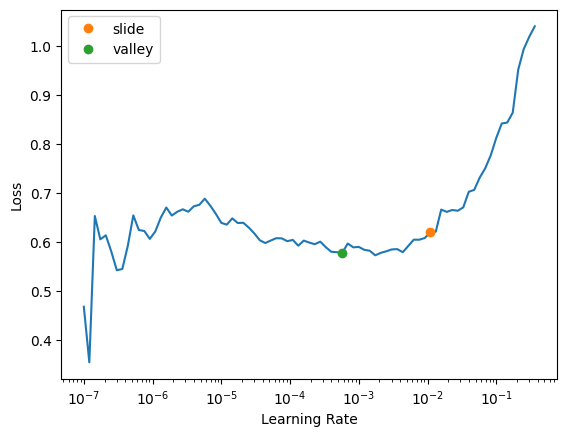

In [ ]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [ ]:
learner.fit_one_cycle(n_epoch = 100, lr_max = slice(lr_min, lr_steep), cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=10)) #Takign the average of suggested slide and valley

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.580122,0.491520,0.859879,1.634798,00:21
1,0.593075,0.493898,0.855511,1.638692,00:21
2,0.579084,0.491289,0.856183,1.634422,00:20
3,0.587612,0.487601,0.856519,1.628405,00:21
4,0.605660,0.496677,0.853495,1.643251,00:21
5,0.579914,0.487784,0.856519,1.628702,00:21
6,0.541548,0.494009,0.859207,1.638874,00:21
7,0.563614,0.499035,0.859543,1.647132,00:21
8,0.566229,0.503093,0.853495,1.653829,00:21
9,0.613305,0.499532,0.853831,1.647951,00:21


No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

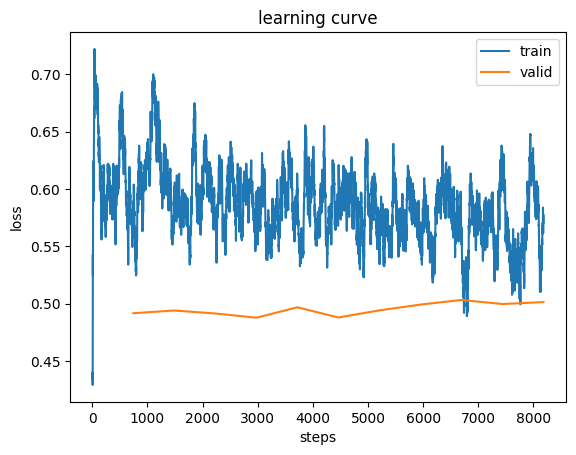

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save(f"sctc_lm-stage-1")

Path('models/sctc_lm-stage-1.pth')

In [ ]:
torch.save(dls, "models/dls_single_class_text_classification_sctc_lm-stage-1.pkl")

**Stage - 2**

In [ ]:
# learner.load(f"sctc_lm-stage-1")

In [ ]:
learner.freeze_to(-3)

Suggested learning rate (slide): 0.0006918309954926372
Suggested learning rate (valley): 3.630780702224001e-05
Average learning rate: 0.0003640694012574386
Suggested ALR: 0.36e-3


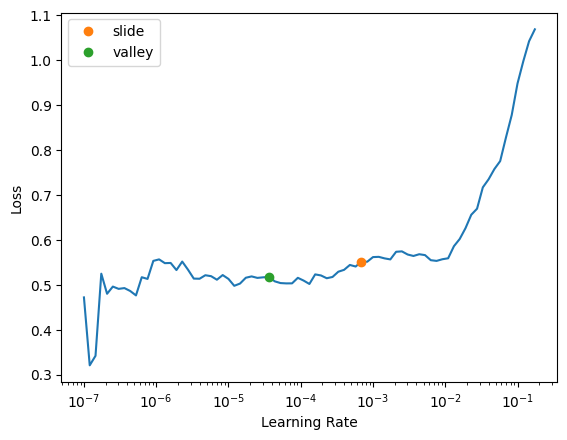

In [ ]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [ ]:
learner.fit_one_cycle(n_epoch = 100, lr_max = slice(lr_min, lr_steep), cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=10)) #Takign the average of suggested slide and valley

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.532324,0.502562,0.857191,1.652951,00:27
1,0.549340,0.494193,0.859543,1.639174,00:28
2,0.543409,0.494593,0.862567,1.639831,00:28
3,0.564304,0.492928,0.860887,1.637103,00:29
4,0.537835,0.489772,0.861559,1.631944,00:28
5,0.496488,0.493346,0.859879,1.637787,00:28
6,0.526380,0.492810,0.859543,1.636909,00:28
7,0.514410,0.487982,0.861223,1.629026,00:28
8,0.536183,0.489782,0.862231,1.631960,00:28
9,0.475815,0.488019,0.862231,1.629086,00:29


No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

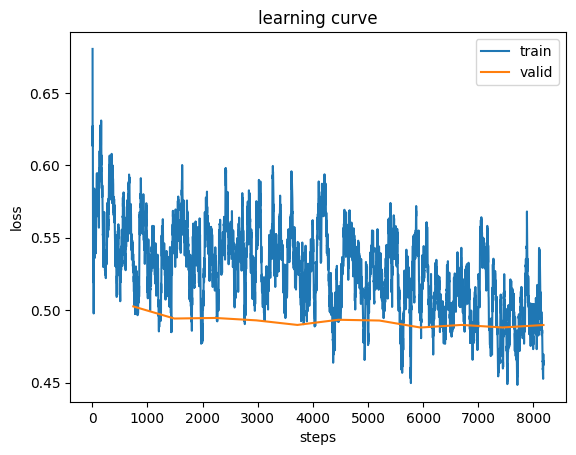

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save(f"sctc_lm-stage-2")

Path('models/sctc_lm-stage-2.pth')

In [ ]:
torch.save(dls, "models/dls_single_class_text_classification_sctc_lm-stage-2.pkl")

**Stage - 3**

In [ ]:
# learner.load(f"sctc_lm-stage-2")

In [ ]:
learner.unfreeze()

Suggested learning rate (slide): 0.033113110810518265
Suggested learning rate (valley): 0.0010000000474974513
Average learning rate: 0.017056555429007858
Suggested ALR: 17.06e-3


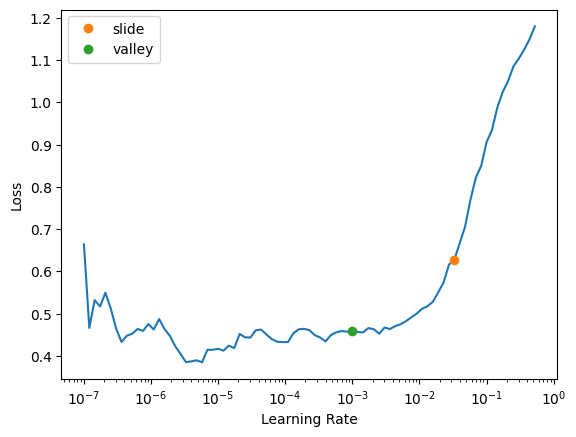

In [ ]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(
    slide, # suggests a learning rate based on the point where the loss starts to decrease most steeply
    valley # suggests a learning rate based on the point where the loss reaches its lowest value before increasing again
))

print(f"Suggested learning rate (slide): {lr_min}")
print(f"Suggested learning rate (valley): {lr_steep}")
average_lr = (lr_min + lr_steep) / 2
print(f"Average learning rate: {average_lr}")
sugg_alr = round((average_lr*1000),2)
print(f"Suggested ALR: {sugg_alr}e-3")

In [ ]:
learner.fit_one_cycle(n_epoch = 100, lr_max = slice(lr_min, lr_steep), cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=10)) #Takign the average of suggested slide and valley

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.515591,0.475024,0.866935,1.608053,00:35
1,0.453478,0.481951,0.862231,1.619231,00:38
2,0.378454,0.515346,0.858199,1.674217,00:38
3,0.297215,0.533267,0.856183,1.704492,00:38
4,0.312596,0.577676,0.844086,1.781892,00:36
5,0.340524,0.617480,0.835349,1.854249,00:36
6,0.385510,0.693441,0.812500,2.000588,00:38
7,0.384152,0.825774,0.768481,2.283648,00:38
8,0.544000,1.054869,0.699597,2.871599,00:39
9,0.788268,1.292348,0.625000,3.641328,00:38


No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

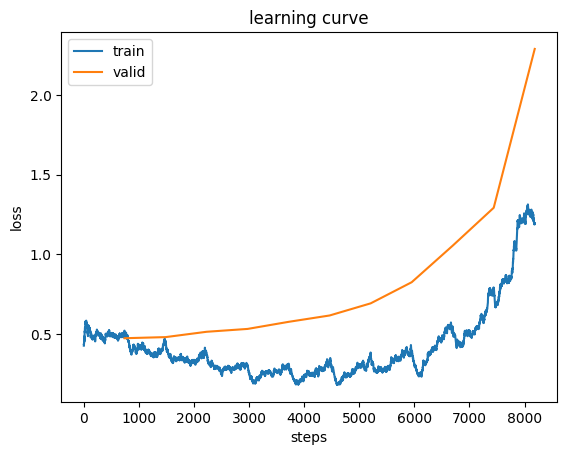

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save(f"sctc_lm-stage-3")

Path('models/sctc_lm-stage-3.pth')

In [ ]:
torch.save(dls, "models/dls_single_class_text_classification_sctc_lm-stage-3.pkl")

**4 stage finetuning is the approach taken by [ULMFit Paper](https://arxiv.org/abs/1801.06146)**


